## Introdução as *ConvNets* biblioteca Keras

Neste notebook iremos praticar a sintaxe básica para treinar uma rede neural artificial convolucional utilizando as bibliotecas [Tensorflow](https://www.tensorflow.org/) e [Keras](https://www.tensorflow.org/api_docs/python/tf/keras).

<br/><br/>
Embora nós iremos importar diretamente apenas objetos e funções da biblioteca Keras, a biblioteca tensorflow é necessária para que o treinamento das redes neurais seja feito.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

A biblioteca Keras possui diversos datasets pré-processados para facilitar a execução de testes. Além disso, essa disponibilização facilita o aprendizado de sua utilização.

<br/><br/>

Abaixo iremos importar o dataset MNIST, o qual foi utilizado na semana passada com o notebook anterior. Note que o formato utilizado pela biblioteca Keras é diferente daquele utilizado por nós na última aula e, portanto, será feito um novo download do mesmo.

In [ ]:
train, train_info = tfds.load('mnist', split='train', with_info=True, batch_size=-1)
test, test_info = tfds.load('mnist', split='test', with_info=True, batch_size=-1)

train = tfds.as_numpy(train)
test = tfds.as_numpy(test)

x_train, y_train = train["image"], train["label"]
x_test, y_test = test["image"], test["label"]

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


O dataset MNSIT é um dataset clássico utilizado para avaliação de métodos de redes neurais há mais de 20 anos.

<br/>

Este dataset é composto de imagens digitalizadas de números de 0 a 9 e, portanto, possui 10 classes. Cada imagem digitalizada possui tamanho 28 pixels x 28 pixels e, portanto, possui 784 pixels no total. Desta forma, a entrada para rede neural terá 784 *features*.


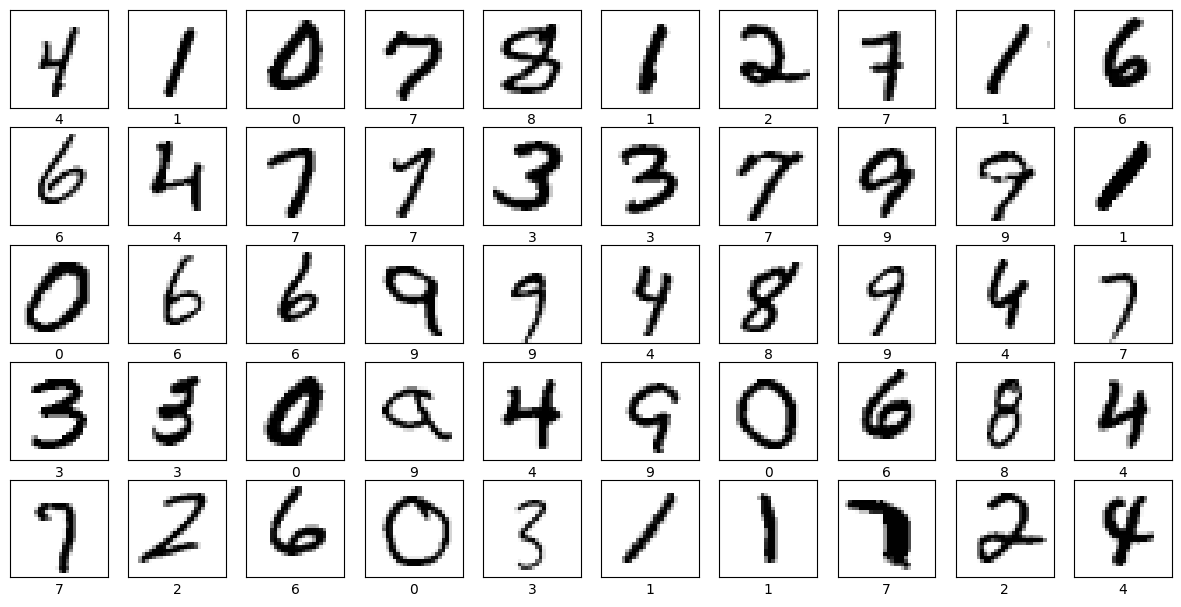

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()



<br/>

No total são 60.000 exemplos para treino e 10.000 exemplos para teste. Embora na prática evite-se utilizar uma partição fixa, esta divisão padrão nos permite comparar diretamente a performance de diversos algoritmos de *machine learning*.

<br/>

A biblioteca Keras fornece algumas funções úteis para fazermos o pré-processamento dos datasets conforme a necessidade. Neste caso, iremos transformar os *targets* em classes para realizar classificações com a rede neural que iremos treinar.

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.16, stratify=y_train, random_state=42)

print(x_train.shape[0], 'exemplos de treino')
print(x_val.shape[0], 'exemplos de validação')
print(x_test.shape[0], 'exemplos de teste')

41328 exemplos de treino
9072 exemplos de validação
10000 exemplos de teste


In [ ]:
from sklearn.model_selection import train_test_split

x_train = x_train.reshape(-1, 28, 28, 1)  ## reorganizando o dataset de treino em 50400 exemplos de tamanho 28x28 e 1 canal de cores
x_val = x_val.reshape(-1, 28, 28, 1)  ## reorganizando o dataset de treino em 9600 exemplos de tamanho 28x28 e 1 canal de cores
x_test = x_test.reshape(-1, 28, 28, 1)  ## reorganizando o dataset de teste em 10000 exemplos de tamanho 28x28 e 1 canal de cores
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes) ## transformando os targets do dataset de treino em classes
y_val = tf.keras.utils.to_categorical(y_val, num_classes) ## transformando os targets do dataset de treino em classes
y_test = tf.keras.utils.to_categorical(y_test, num_classes)  ## transformando os targets do dataset de teste em classes

O modelo básico da biblioteca Keras é o modelo `Sequential`. Este modelo nos permite adicionar camadas na rede neural que serão processadas na sequência em que forem inseridas.

<br/>

Ao criarmos um objeto deste tipo, podemos adicionar as camadas utilizando o método `add` do modelo. Até o momento, vimos apenas as camadas básicas da rede neural e que são chamadas de camadas `Dense` pela biblioreca Keras. Vimos também na aula de hoje as camadas convolucionais e de pooling, chamadas de *Conv2D* e *MaxPooling2D* pela biblioteca Keras.

<br/>

Para cada camada adicionada devemos fornecer o número de neurônios da camada, sua função de ativação, a função de inicialização dos parâmetros $W$'s e dos parâmetros $b$'s, e ainda se desejamos utilizar ou não os parâmetros $b$'s. Note que para a primeira camada do modelo, devemos fornecer o parâmetro `input_shape` que indica o número de features que servirão como *input* para a rede neural. Note também que não há a camada de entrada que possui função de ativação identidade.

<br />

Para as camadas *Conv2D* e *MaxPooling2D* nós devemos, além de fornecer o número de *feature maps*, também fornecer o tamanho dos *features maps* que serão aplicados pelas convoluções. Um exemplo de uma definição de camada *Conv2D* seguido de uma camada *MaxPooling2D*:

<br/>

```python
Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(28, 28, 1))
MaxPooling2D((2, 2))
```

<br/>

Note que devemos passar no `input_shape` da camada *Conv2D*, devemos fornecer uma tupla contendo o tamanho das imagens e o número de canais de cores utilizados. Note também que para o *MaxPooling2D* não é necessário fornecer o número de operações, pois será automaticamente aplicada 1 operação de *MaxPooling2D* para cada *feature map*.

<br />

Após as camadas de convolução, precisamos obrigatoriamente adicionar uma camada *tradicional* na rede neural ou, caso contrário, não será possível obter a previsão/classificação da rede. Nós obtemos isso utilizando a camada `Flatten()` da biblioteca Keras. Esta camada simplesmente pega todos os *feature maps* da camada anterior de convolução e os organize num vetor de *features* para inserção numa camada `Dense`. Exemplo de utilização:

```python
model.add(Flatten())
```

In [ ]:
# possibilidades de ativação para camadas intermediárias: 'relu', 'sigmoid', 'tahn'
# possibilidades de ativação para última camada: 'relu', 'sigmoid', 'tahn', 'softmax'

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(30, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))

# abaixo definimos uma camada de 10 neurônios (que é o número de classes do nosso problema), com ativação softmax,
# inicialização glorot para os parâmetros e inicialização igual a 0 para os parâmetros bias
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 30)                1

Antes de treinarmos o modelo, precisamos fazer sua compilação com o método `compile`. Isto utilizará a biblioteca tensorflow que fará diversas otimizações no código e irá gerar um executável na linguagem `C` (que não está imediatamente disponível para nós).

<br/>

Para compilar o código, precisamos passar qual a função de perda (`loss`), qual otimizador será utilizado para o treinamento (`optimizer`) e qual métrica será utilizada durante o treinamento para monitorarmos o progresso.

<br/>

A biblioteca keras oferece diversos otimizadores para treinamento. Para escolhermos, basta importar o otimizador desejado e fornecer para o método `compile`.

In [ ]:
# aqui utilizaremos a função categorical_crossentropy pois são mais de 2 classes e
# otimizador RMSprop enquanto monitoramos a evolução da acurácia para o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

history = model.fit(x_train, y_train,
                    batch_size=20,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test top-5 accuracy:', score[2])

Epoch 1/10
2520/2520 [==============================] - 21s 4ms/step - loss: 0.1889 - accuracy: 0.9425 - top_k_categorical_accuracy: 0.9953 - val_loss: 14.4973 - val_accuracy: 0.9707 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
2520/2520 [==============================] - 10s 4ms/step - loss: 0.0703 - accuracy: 0.9786 - top_k_categorical_accuracy: 0.9996 - val_loss: 15.2431 - val_accuracy: 0.9766 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
2520/2520 [==============================] - 10s 4ms/step - loss: 0.0522 - accuracy: 0.9839 - top_k_categorical_accuracy: 0.9998 - val_loss: 13.7271 - val_accuracy: 0.9793 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
2520/2520 [==============================] - 11s 4ms/step - loss: 0.0433 - accuracy: 0.9866 - top_k_categorical_accuracy: 0.9999 - val_loss: 23.1068 - val_accuracy: 0.9739 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
2520/2520 [==============================] - 11s 4ms/step - loss: 0.0358 - accuracy: 0.9894 -

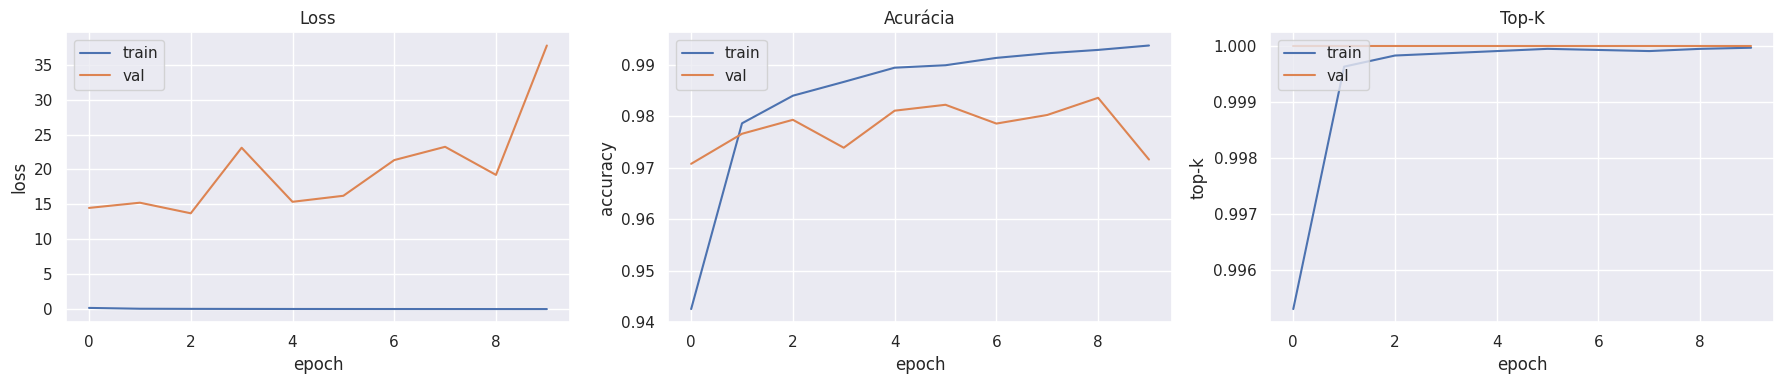

In [ ]:
import seaborn as sns
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'val'], loc='upper left')

# acurácia
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Acurácia')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train', 'val'], loc='upper left')

# acurácia top-k
ax3.plot(history.history['top_k_categorical_accuracy'])
ax3.plot(history.history['val_top_k_categorical_accuracy'])
ax3.set_title('Top-K')
ax3.set(xlabel='epoch', ylabel='top-k')
ax3.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

A biblioteca Keras possui uma interface compatível com a biblioteca [scikit-learn](https://scikit-learn.org/stable/index.html), que é padrão para praticantes de *machine learning*. Por isso, podemos utilizar objetos e funções desta biblioteca para calcular métricas mais avançadas, como * precision*, * recall*  e * f1-score*.

<br/>

Note que a rede neural faz uma previsão do * score*  para cada classe possível para cada exemplo no dataset. Ou seja, para cada exemplo, a saída da rede neural será um *score* para cada classe possível. No nosso caso são 10 classes e por isso a saída da rede neural conterá 10 *scores* para cada exemplo.

<br/>

Em função desta saída em formato de scores, precisamos ober o score mais alto obtido para cada exemplo. Este * score*  irá nos dizer qual a classe foi prevista pela rede neural com um grau de confiança maior. Isso será obtido pela função `argmax` da biblioteca numpy

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print('Acurácia: {:.4f}'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred)))

print('\n\nDemais métricas (separadas por classe): ')
print(classification_report(np.argmax(y_test, axis=1), y_pred))

313/313 [==============================] - 1s 2ms/step
Acurácia: 0.9874


Demais métricas (separadas por classe): 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.96      1.00      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
y_pred

array([2, 0, 4, ..., 8, 0, 5])

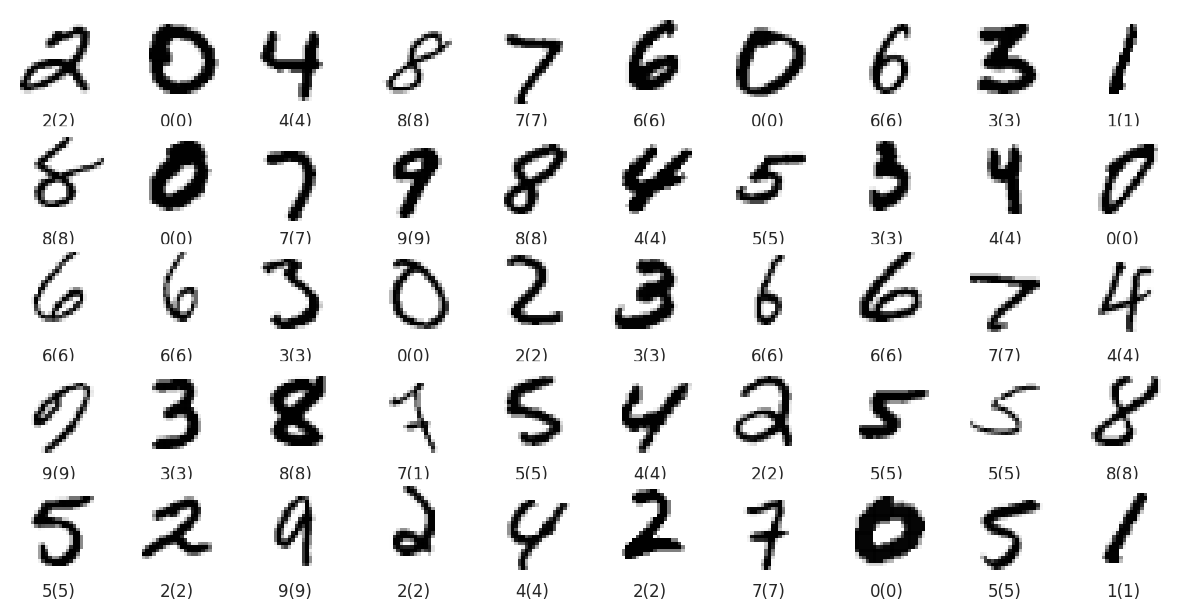

In [ ]:

plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel("{}({})".format(np.argmax(y_test, axis=1)[i], y_pred[i]))
plt.show()

## Exercício *Fashion MNIST*

Agora vamos praticar as *Conv Nets* com outro dataset em similar ao MNIST: o *Fashion MNIST*.

O *Fashion MNIST* é um dataset que contém imagens de peças de vestuário organizadas da mesma forma que o MNIST original.



In [ ]:
train, train_info = tfds.load('fashion_mnist', split='train', with_info=True, batch_size=-1)
test, test_info = tfds.load('fashion_mnist', split='test', with_info=True, batch_size=-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8F1CBF/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8F1CBF/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Insira abaixo o código para criar um modelo para o *Fashion MNIST*:

Insira abaixo o código para treinar e avaliar o modelo no *Fashion MNIST*.